In [2]:
from dendrocat import RadioSource
from astropy.io import fits
from spectral_cube import SpectralCube
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import sys
import importlib
from astropy.wcs import WCS
from scipy import interpolate
import pandas as pd
import sympy as syp
from astropy import units as u
import radio_beam
from astropy.table import Table
from radio_beam import Beam
from astropy import coordinates
from astropy import wcs
from astropy.nddata.utils import Cutout2D
from dendrocat.aperture import Ellipse

W51 = '/orange/adamginsburg/w51/TaehwaYoo/'
W51b6 = '/orange/adamginsburg/w51/TaehwaYoo/2015.1.01596.S_W51_B6_LB/continuum_images/'
W51cont='/orange/adamginsburg/w51/TaehwaYoo/b6contfits/'
w51e2_b6_briggs=W51cont+'W51e2_cont_bigbriggs.image.fits'
w51e2_b6_robust0=W51cont+'W51e2_cont_big_robust0.image.fits'
w51e2_b6_uniform=W51cont+'W51e2_cont_biguniform.image.fits'
w51e2_b6_superuniform=W51cont+'W51e2_cont_bigsuperuniform.image.fits'

w51n_b6_briggs = W51cont+'W51n_cont_bigbriggs.image.fits'
w51n_b6_robust0 = W51cont+'w51n_cont_big_robust0.image.fits'
w51n_b6_uniform = W51cont+'W51n_cont_biguniform.image.fits'
w51n_b6_superuniform = W51cont+'W51n_cont_bigsuperuniform.image.fits'
w51n_b6_natural = W51cont+'W51n_cont_bignatural.image.fits'

W51b3 = '/orange/adamginsburg/w51/TaehwaYoo/2017.1.00293.S_W51_B3_LB/may2021_successful_imaging/'

w51n_b3_tt0 = W51b3+'w51n.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt0.pbcor.fits'
w51n_b3_tt1 = W51+'w51n.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt1.pbcor.fits'
w51n_b3_alpha = W51+'w51n.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.alpha.pbcor.fits'

w51conv = '/orange/adamginsburg/w51/TaehwaYoo/convolved_new/'
w51n_b6_conv = w51conv + 'w51n_cont_bigbriggs.image.convB3_briggs.fits'

w51e_b3_tt0 = W51b3+'w51e2.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt0.pbcor.fits'
w51e_b3_tt1 = W51+'w51e2.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt1.pbcor.fits'
w51e_b3_alpha = W51+'w51e2.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.alpha.pbcor.fits'

w51e_b6_conv_old = w51conv + 'w51e2_cont_bigbriggs.image.convB3_briggs.fits'
w51e_b6_conv = w51conv + 'w51e_new_B6_conv.fits'
w51n_b6_conv = w51conv + 'w51n_new_B6_conv.fits'

w51e_b6_almaimf_conv = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51e_B6_conv.fits'
w51e_b3_almaimf_conv = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51e_B3_conv.fits'


w51n_b3_almaimf_conv = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51n_B3_conv.fits'

w51n_b6_almaimf = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/W51-IRS2_B6_uid___A001_X1296_X187_continuum_merged_12M_robust0_selfcal9_finaliter.image.tt0.pbcor.fits'

w51n_b6_conv_old = w51conv + 'w51n_B6_conv.fits'
w51n_b3_conv_old = w51conv + 'w51n_B3_conv.fits'
w51e_b3_conv_old = w51conv + 'w51e_B3_conv.fits'
w51e_b6_conv_old = w51conv + 'w51e_B6_conv.fits'



w51e_dendro_matched_catalog = '/home/t.yoo/w51/catalogue/dendrogram/dendro_w51e_matched.fits'
w51n_dendro_matched_catalog = '/home/t.yoo/w51/catalogue/dendrogram/dendro_w51n_matched.fits'

w51e_b6_background = '/home/t.yoo/w51/catalogue/dendrogram/background_noise_w51e_b6_pb.dat'
w51e_b3_background = '/home/t.yoo/w51/catalogue/dendrogram/background_noise_w51e_b3_pb.dat'
w51n_b6_background = '/home/t.yoo/w51/catalogue/dendrogram/background_noise_w51n_b6_pb.dat'
w51n_b3_background = '/home/t.yoo/w51/catalogue/dendrogram/background_noise_w51n_b3_pb.dat'


In [3]:

def flux_from_pixel(xpos,ypos,image,pixel_scale,beam):
    flux_i = image[int(ypos),int(xpos)]
    pixel_scale_sr = (pixel_scale.value * np.pi/180)**2
    beamarea  = beam.sr.value
    flux = flux_i /beamarea * pixel_scale_sr
    
    return flux

def flux_from_peak(image,hdrNB, table_highres, band='', isresized=False):
    if band is 'B3':
        bandindex = '_b3'
    elif band is 'B6':
        bandindex = '_b6'
    else:
        bandindex =''

    wcsNB = WCS(hdrNB,naxis=2)
    scaleNB = wcsNB.proj_plane_pixel_scales()[0]
    print(scaleNB)
    my_beamNB = Beam.from_fits_header(hdrNB)    
    x_sky = table_highres['x_sky%s'%bandindex]
    y_sky = table_highres['y_sky%s'%bandindex]

    xy_sky = np.vstack((x_sky,y_sky)).T
    xy_pos = wcsNB.wcs_world2pix(xy_sky,0)
    x_pos = xy_pos[:,0] ; y_pos = xy_pos[:,1]
    num_source = len(x_sky)

    fluxfrompeak = []
    if isresized: #same pixel size
        for i in range(num_source):
            fluxfrompeak.append(image[int(y_pos[i]),int(x_pos[i])])
    else:
        for i in range(num_source):
            flux= flux_from_pixel(x_pos[i],y_pos[i],image,scaleNB,my_beamNB)
            fluxfrompeak.append(flux)
    
    return np.array(fluxfrompeak)

def cen_freq(center, delta ,alpha=2):
    start = center-delta/2 ; end = center+delta/2
    freqarr = np.logspace(np.log10(start),np.log10(end),20)
    dfreq = freqarr[1:]-freqarr[:-1]
    dfreq = np.append(dfreq,[dfreq[-1]])
    
    integral_up = np.sum(freqarr**(alpha+1)*dfreq)
    integral_down = np.sum(freqarr**(alpha)*dfreq)
    return integral_up/integral_down

def comp_alpha_from_peak_aper(ax,B3data,B6data,combined_table,reproject=None):
    hdrNB6 = fits.getheader(B6data)  
    hdrNB3 = fits.getheader(B3data)  
    fitsdata_b3 = fits.open(B3data)
    fitsdata_b6 = fits.open(B6data)
    wcsNB3 = WCS(hdrNB3,naxis=2)
    wcsNB6 = WCS(hdrNB6,naxis=2)

    
    B3image = fitsdata_b3[0].data
    if len(B3image.shape)!=2:
        B3image = fitsdata_b3[0].data[0][0]
    B6image = fitsdata_b6[0].data
    if len(B6image.shape)!=2:
        B6image = fitsdata_b6[0].data[0][0]
    
    isresized=False
    if reproject=='B3':
        B3data, footprint = reproject_exact((B3image,wcsNB3),wcsNB6,shape_out=B6image.shape)
        isresized=True
    elif reproject=='B6':
        B6data, footprint = reproject_exact((B6image,wcsNB6),wcsNB3,shape_out=B3image.shape)
        isresized=True
    B3flux = flux_from_peak(B3image,hdrNB3,combined_table,isresized=isresized)
    B6flux = flux_from_peak(B6image,hdrNB6,combined_table,isresized=isresized)
    print(B3flux, B6flux)
 
    freqb3 = cen_freq(hdrNB3['CRVAL3'],hdrNB3['CDELT4'])
    freqb6 = cen_freq(hdrNB6['CRVAL4'],hdrNB6['CDELT4'])
    alpha = np.log10(B3flux/B6flux)/np.log10(freqb3/freqb6)
    
    alpha_from_aper = combined_table['alpha']
    
    ax.scatter(alpha_from_aper, alpha,c='k')
    ax.set_xlabel('alpha from aperture')
    ax.set_ylabel('alpha from peak pixel')






Text(0, 0.5, 'spectral index from peak pixel')

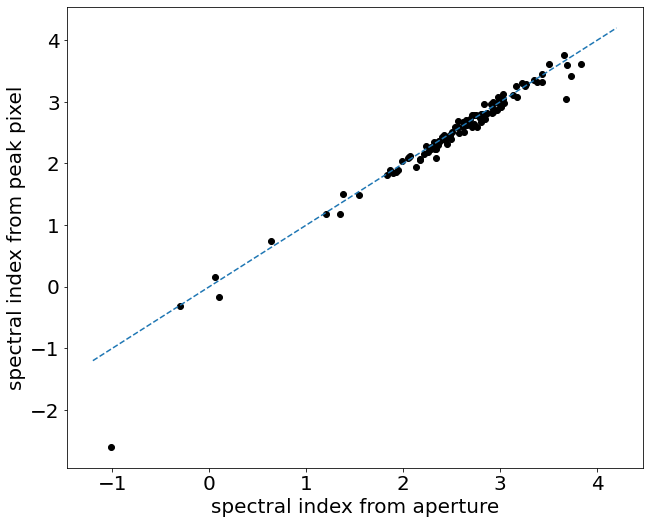

In [4]:

plt.rcParams['axes.labelsize']=20
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['axes.titlesize']=20


fig = plt.figure(figsize=(10,8))
ax1=fig.add_axes([0.1,0.1,0.8,0.8])
combined_table = Table.read('/home/t.yoo/w51/catalogue/photometry/dendro_w51e_matched_flux.fits',format='fits')

fitsdata_b3 = fits.open(w51e_b3_tt0)
image_b3 = fitsdata_b3[0].data
if len(image_b3.shape)>2:
    image_b3 = fitsdata_b3[0].data[0][0]
    
fitsdata_b6 = fits.open(w51e_b6_conv)
image_b6 = fitsdata_b6[0].data

if len(image_b6.shape)>2:
    image_b6 = fitsdata_b6[0].data[0][0]


hdrNB3 = fits.getheader(w51e_b3_tt0)  
hdrNB6 = fits.getheader(w51e_b6_conv)  
wcsNB3 = WCS(hdrNB3,naxis=2)
wcsNB6 = WCS(hdrNB6,naxis=2)

my_beamNB6 = Beam.from_fits_header(hdrNB6)
my_beamNB3 = Beam.from_fits_header(hdrNB3)

scaleNB6 = wcsNB6.proj_plane_pixel_scales()[0]
scaleNB3 = wcsNB3.proj_plane_pixel_scales()[0]

peakflux_b3 = combined_table['peak_flux_b3']
peakflux_b6 = combined_table['peak_flux_conv_b6']

beamflux_b3 = combined_table['beam_flux_b3']
beamflux_b6 = combined_table['beam_flux_conv_b6']

freqb3 = cen_freq(hdrNB3['CRVAL3'],hdrNB3['CDELT4'])
freqb6 = cen_freq(hdrNB6['CRVAL4'],hdrNB6['CDELT4'])

alpha_peak = np.log10(peakflux_b3/peakflux_b6)/np.log10(freqb3/freqb6)
alpha_beam = np.log10(beamflux_b3/beamflux_b6)/np.log10(freqb3/freqb6)
ax1.scatter(alpha_beam, alpha_peak,c='k')
ax1.plot([-1.2,4.2],[-1.2,4.2],ls='dashed')
ax1.set_xlabel('spectral index from aperture')
ax1.set_ylabel('spectral index from peak pixel')

Text(0, 0.5, 'spectral index ratio')

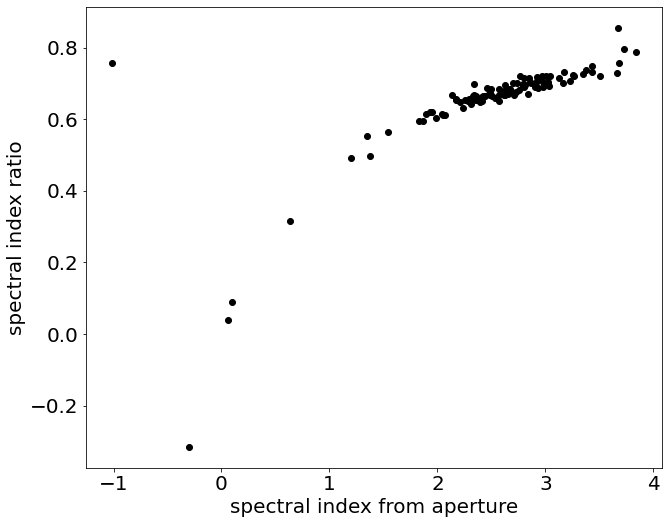

In [5]:

plt.rcParams['axes.labelsize']=20
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['axes.titlesize']=20


fig = plt.figure(figsize=(10,8))
ax1=fig.add_axes([0.1,0.1,0.8,0.8])
combined_table = Table.read('/home/t.yoo/w51/catalogue/photometry/dendro_w51e_matched_flux.fits',format='fits')

fitsdata_b3 = fits.open(w51e_b3_tt0)
image_b3 = fitsdata_b3[0].data
if len(image_b3.shape)>2:
    image_b3 = fitsdata_b3[0].data[0][0]
    
fitsdata_b6 = fits.open(w51e_b6_conv)
image_b6 = fitsdata_b6[0].data

if len(image_b6.shape)>2:
    image_b6 = fitsdata_b6[0].data[0][0]


hdrNB3 = fits.getheader(w51e_b3_tt0)  
hdrNB6 = fits.getheader(w51e_b6_conv)  
wcsNB3 = WCS(hdrNB3,naxis=2)
wcsNB6 = WCS(hdrNB6,naxis=2)

my_beamNB6 = Beam.from_fits_header(hdrNB6)
my_beamNB3 = Beam.from_fits_header(hdrNB3)

scaleNB6 = wcsNB6.proj_plane_pixel_scales()[0]
scaleNB3 = wcsNB3.proj_plane_pixel_scales()[0]

peakflux_b3 = combined_table['peak_flux_b3']
peakflux_b6 = combined_table['peak_flux_conv_b6']

beamflux_b3 = combined_table['beam_flux_b3']
beamflux_b6 = combined_table['beam_flux_conv_b6']

freqb3 = cen_freq(hdrNB3['CRVAL3'],hdrNB3['CDELT4'])
freqb6 = cen_freq(hdrNB6['CRVAL4'],hdrNB6['CDELT4'])

alpha_peak = np.log10((peakflux_b3/scaleNB3.value**2)/(peakflux_b6/scaleNB6.value**2))/np.log10(freqb3/freqb6)
alpha_beam = np.log10(beamflux_b3/beamflux_b6)/np.log10(freqb3/freqb6)
ax1.scatter(alpha_beam, alpha_beam/alpha_peak,c='k')
#ax1.plot([-1.2,4.2],[-1.2,4.2],ls='dashed')
ax1.set_xlabel('spectral index from aperture')
ax1.set_ylabel('spectral index ratio')

new vs old image

      x_sky              y_sky        x_pix y_pix   alpha            b3flux                 b6flux         kind
------------------ ------------------ ----- ----- ---------- ---------------------- ---------------------- ----
 290.9323236580427 14.505409165819163  7566  5089  1.6407931 0.00016104403766803443 0.00022419153538066894  0.0
290.93224934308944 14.505939998942365  7603  5362  1.9308852  0.0005685356445610523  0.0010117175988852978  0.0
 290.9323598082871 14.506204443693052  7548  5498  1.4927144  0.0010294992243871093  0.0012472550151869655  0.0
290.93248031666974 14.506218055078794  7488  5505  1.4130402  0.0007158563239499927  0.0007884643855504692  0.0
 290.9324280963174 14.506233610522942  7514  5513   1.526292   0.000687902036588639  0.0008371498552151024  0.0
 290.9325767229294 14.506494166365767  7440  5647   1.688955 0.00034318759571760893  0.0004980514640919864  0.0
 290.9326269340943 14.506988055331066  7415  5901  1.7570441 0.00038460196810774505  0.00056792388204485

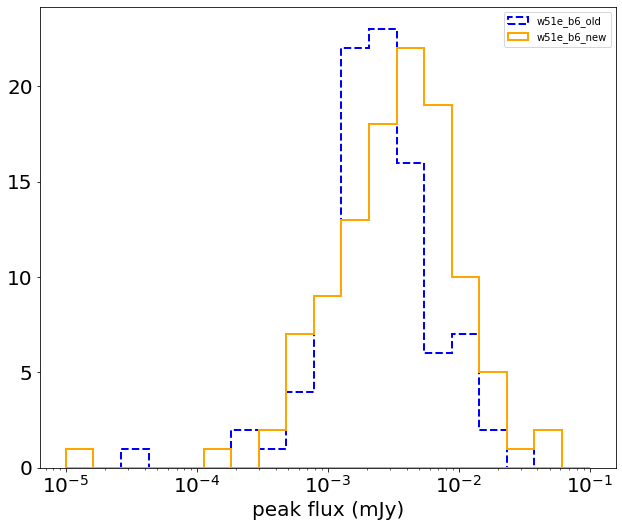

In [16]:

plt.rcParams['axes.labelsize']=20
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['axes.titlesize']=20


fig = plt.figure(figsize=(10,8))
ax1=fig.add_axes([0.1,0.1,0.8,0.8])
combined_table = Table.read('/home/t.yoo/w51/catalogue/photometry/dendro_w51e_matched_flux.fits',format='fits')

fitsdata_b3 = fits.open(w51e_b3_tt0)
image_b3 = fitsdata_b3[0].data
if len(image_b3.shape)>2:
    image_b3 = fitsdata_b3[0].data[0][0]
    
fitsdata_b6 = fits.open(w51e_b6_conv)
image_b6 = fitsdata_b6[0].data

if len(image_b6.shape)>2:
    image_b6 = fitsdata_b6[0].data[0][0]


hdrNB3 = fits.getheader(w51e_b3_tt0)  
hdrNB6 = fits.getheader(w51e_b6_conv)  
wcsNB3 = WCS(hdrNB3,naxis=2)
wcsNB6 = WCS(hdrNB6,naxis=2)

my_beamNB6 = Beam.from_fits_header(hdrNB6)
my_beamNB3 = Beam.from_fits_header(hdrNB3)

scaleNB6 = wcsNB6.proj_plane_pixel_scales()[0]
scaleNB3 = wcsNB3.proj_plane_pixel_scales()[0]

peakflux_b3 = combined_table['peak_flux_b3']
peakflux_b6 = combined_table['peak_flux_conv_b6']

beamflux_b3 = combined_table['beam_flux_b3']
beamflux_b6 = combined_table['beam_flux_conv_b6']

freqb3 = cen_freq(hdrNB3['CRVAL3'],hdrNB3['CDELT4'])
freqb6 = cen_freq(hdrNB6['CRVAL4'],hdrNB6['CDELT4'])

alpha_peak = np.log10(peakflux_b3/peakflux_b6)/np.log10(freqb3/freqb6)
alpha_beam = np.log10(beamflux_b3/beamflux_b6)/np.log10(freqb3/freqb6)


combined_table_old = Table.read('/home/t.yoo/w51/catalogue/spectral_index/w51e_combined_catalog.fits',format='fits')
print(combined_table_old)
xysky = np.vstack((combined_table_old['x_sky'], combined_table_old['y_sky'])).T
fitsdata_old = fits.open(w51e_b6_conv_old)

image_old = fitsdata_old[0].data
if len(image_old.shape)>2:
    image_old = fitsdata_old[0].data[0][0]
hdrold = fits.getheader(w51e_b6_conv_old)  
wcsold = WCS(hdrold,naxis=2)
xypix = wcsold.wcs_world2pix(xysky,0)
flux_from_peak_old = image_old[xypix[:,1].astype(int),xypix[:,0].astype(int)]

bin = np.logspace(-5, -1, 20)

ax1.hist(flux_from_peak_old, histtype='stepfilled',facecolor='none',edgecolor='b',ls='dashed',lw=2, label='w51e_b6_old',bins=bin)
ax1.hist(peakflux_b6, histtype='stepfilled',facecolor='none',edgecolor='orange',lw=2, label='w51e_b6_new',bins=bin)

ax1.set_xlabel('peak flux (mJy)')
ax1.set_xscale('log')
plt.legend()


[ 1.8138984e-06 -1.0585636e-05 -2.4594150e-05 ...  5.1081755e-05
  6.5103210e-05  6.9576126e-05]
1.944444444444e-06 deg
[-0.00047594 -0.00049418 -0.00051058 ...  0.00050445  0.00049027
  0.00049324]
1.388888888889e-06 deg
[6.32860672e-06 1.59787248e-05 2.78300357e-05 6.48781182e-04
 3.01314931e-05 1.74398039e-05 1.05559435e-05 7.51309383e-05
 2.79032390e-05 1.49768717e-04 3.46642407e-05 6.81467126e-06
 1.14493925e-05 8.05855800e-06 1.99051495e-05 5.86201052e-05
 8.44947381e-06 4.07515063e-05 3.30196175e-05 3.40433339e-05
 2.58367974e-05 3.48956970e-05] [2.37842155e-05 2.76051849e-05 1.38160856e-05 2.85598863e-04
 7.97712536e-05 6.26226487e-05 3.10138037e-05 1.60254450e-04
 7.84428974e-05 3.33930587e-04 7.92518951e-05 1.74495140e-05
 5.58623035e-05 1.47408970e-05 6.29078395e-05 7.04838663e-05
 2.32635291e-05 4.83889552e-05 6.00355082e-05 6.06435973e-05
 5.86246290e-05 4.33339152e-05]


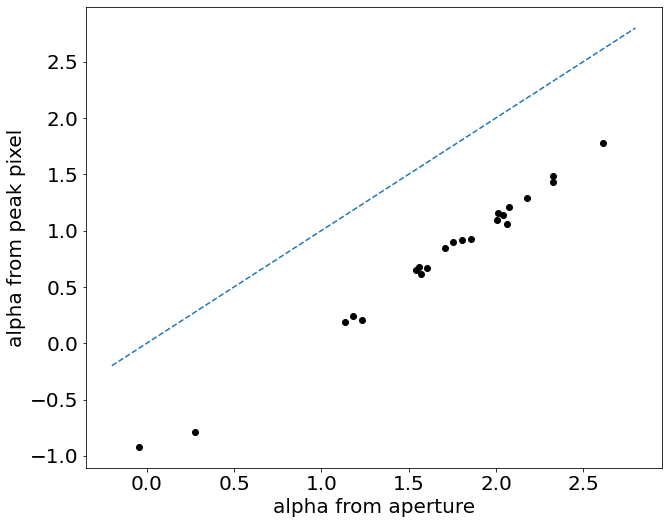

In [10]:

fig = plt.figure(figsize=(10,8))
ax1=fig.add_axes([0.1,0.1,0.8,0.8])
combined_table = Table.read('/home/t.yoo/w51/catalogue/alpha/w51n_combined_catalog.fits',format='fits')

comp_alpha_from_peak_aper(ax1, w51n_b3_tt0, w51n_b6_conv_briggs, combined_table)
ax1.plot([-0.2,2.8],[-0.2,2.8],ls='dashed')

[]
1.944444444444e-06 deg
[-0.00047594 -0.00049418 -0.00051058 ...  0.00050445  0.00049027
  0.00049324]
1.388888888889e-06 deg
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan] [2.37842155e-05 2.76051849e-05 1.38160856e-05 2.85598863e-04
 7.97712536e-05 6.26226487e-05 3.10138037e-05 1.60254450e-04
 7.84428974e-05 3.33930587e-04 7.92518951e-05 1.74495140e-05
 5.58623035e-05 1.47408970e-05 6.29078395e-05 7.04838663e-05
 2.32635291e-05 4.83889552e-05 6.00355082e-05 6.06435973e-05
 5.86246290e-05 4.33339152e-05]


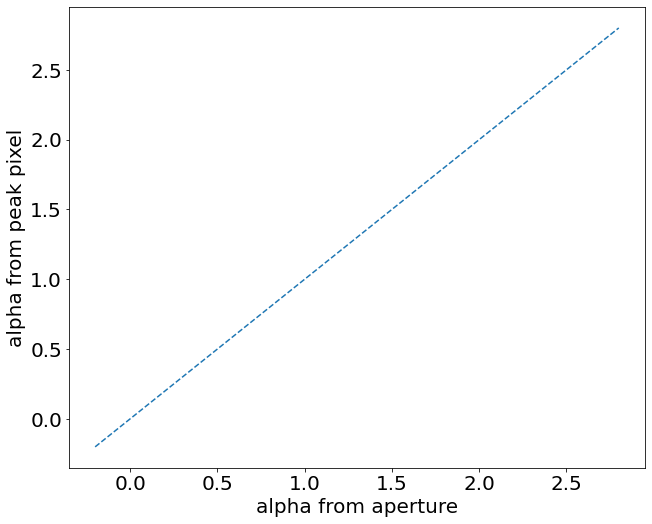

In [11]:



fig = plt.figure(figsize=(10,8))
ax1=fig.add_axes([0.1,0.1,0.8,0.8])
combined_table = Table.read('/home/t.yoo/w51/catalogue/alpha/w51n_combined_catalog.fits',format='fits')

comp_alpha_from_peak_aper(ax1, w51n_b3_tt0_resize, w51n_b6_conv_briggs, combined_table)
ax1.plot([-0.2,2.8],[-0.2,2.8],ls='dashed')

1.944444444444e-06 deg


IndexError: invalid index to scalar variable.

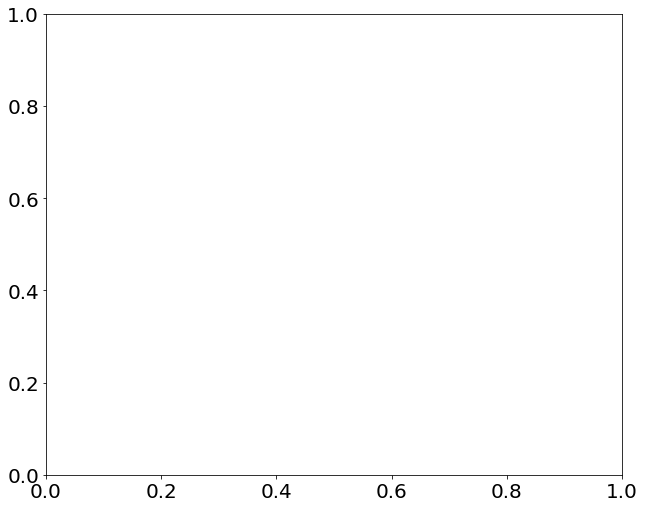

In [5]:



fig = plt.figure(figsize=(10,8))
ax1=fig.add_axes([0.1,0.1,0.8,0.8])
combined_table = Table.read('/home/t.yoo/w51/catalogue/alpha/w51n_combined_catalog.fits',format='fits')

comp_alpha_from_peak_aper(ax1, w51n_b3_tt0, w51n_b6_conv_briggs_resize, combined_table)
ax1.plot([-0.2,2.8],[-0.2,2.8],ls='dashed')